# Fig. 1. Make basemap showing model bathymetry and study area

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

2023-01-18 15:49:23,592 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7__oyxl1', purging
2023-01-18 15:49:23,593 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-llsdxk37', purging
2023-01-18 15:49:23,593 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-z88eixo6', purging
2023-01-18 15:49:23,594 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wmfr_edn', purging
2023-01-18 15:49:23,594 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-euh6x0w0', purging
2023-01-18 15:49:23,594 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d6dcut6v', purging
2023-01-18 15:49:23,595 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cj506i60', purging

In [2]:
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_parent = xroms.open_mfnetcdf(path)
ds_parent, grid_avg = xroms.roms_dataset(ds_parent)

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_child = xroms.open_mfnetcdf(path)
ds_child, grid_avg_child = xroms.roms_dataset(ds_child)

#Parent model slices - see 'grid_sanity_check' in quality_control for more info
xislice = slice(271,404)
etaslice = slice(31,149)

#Child model slices - see 'grid_sanity_check' in quality_control for more info
xislice_child = slice(8, 677-8)
etaslice_child = slice(8, 602-8)

In [3]:
def states_coastline(ax, resolution='10m', linewidth=0.5, color='black', states=True):
	ax.coastlines(resolution=resolution, color=color, linewidth=linewidth)

	states_provinces = cfeature.NaturalEarthFeature(
		    category='cultural',
		    name='admin_1_states_provinces_lakes',
		    scale=resolution,
		    facecolor='none')
	if states:	    
		ax.add_feature(states_provinces, edgecolor=color, linewidth=linewidth)

# Plot the basemap 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/d2/home/dylan/.conda/envs/copano/lib/py

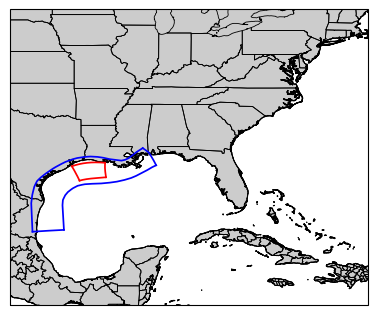

In [4]:
crs = ccrs.PlateCarree(central_longitude=-93.5)

fig, ax = plt.subplots(1, figsize = (1.83*2,1.52*2), subplot_kw={'projection': crs}, constrained_layout = True)

ax.plot(ds_parent.lon_rho[-1,:], ds_parent.lat_rho[-1,:], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[0,:], ds_parent.lat_rho[0,:], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,0], ds_parent.lat_rho[:,0], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,-1], ds_parent.lat_rho[:,-1], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())

ax.plot(ds_child.lon_rho[0,:], ds_child.lat_rho[0,:], 'r', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_child.lon_rho[:,0], ds_child.lat_rho[:,0], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[:,-1], ds_child.lat_rho[:,-1], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[-1,:], ds_child.lat_rho[-1,:], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.set_extent([-100, -70, 16, 44], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect('auto')

# plt.savefig('gom_zoomed_out.jpg', dpi = 300)  

# Plot study area and bathymetry. Combine these two figures offline.

Text(-90.5, 30.5, 'Mississippi River')

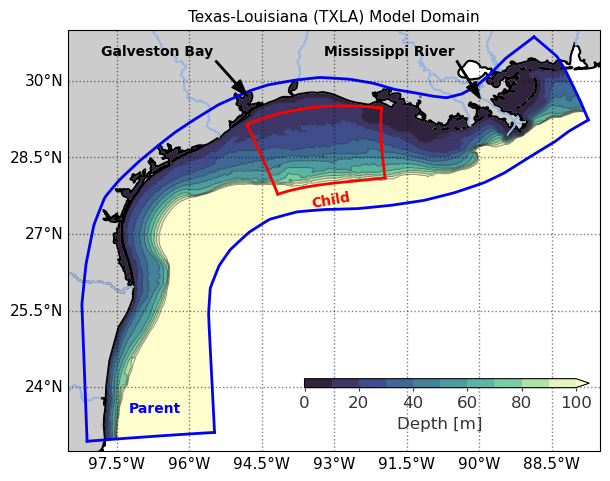

In [5]:
plt.rcParams.update({'font.size': 11})
hlevs = np.arange(10,110,10)  # isobath contour depths

crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1, figsize = (5.4,4.5), subplot_kw={'projection': crs}, constrained_layout = True)

#Plot the depth. 
mappable = ax.contourf(ds_parent.lon_rho,
                       ds_parent.lat_rho,
                       ds_parent.h, 
                       cmap = cmo.deep_r,
                       levels = [0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100],
                       extend = 'max',
                       transform = ccrs.PlateCarree())

ax.contour(ds_parent.lon_rho.values, 
           ds_parent.lat_rho.values, 
           ds_parent.h, hlevs, 
           colors='0.15', 
           transform=ccrs.PlateCarree(), 
           linewidths=.75, alpha = 0.5)

ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())

#Add grid boundaries. Parent then child. 
ax.plot(ds_parent.lon_rho[-1,:], ds_parent.lat_rho[-1,:], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[0,:], ds_parent.lat_rho[0,:], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,0], ds_parent.lat_rho[:,0], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,-1], ds_parent.lat_rho[:,-1], 'b', lw=2,transform = cartopy.crs.PlateCarree())

ax.plot(ds_child.lon_rho[0,:], ds_child.lat_rho[0,:], 'r', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_child.lon_rho[:,0], ds_child.lat_rho[:,0], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[:,-1], ds_child.lat_rho[:,-1], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[-1,:], ds_child.lat_rho[-1,:], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)

#Colorbar
cax = fig.add_axes([0.445, 0.15, 0.5275, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth [m]', fontsize=12, color='0.2')
cb.ax.tick_params(labelsize=12, length=2, color='0.2', labelcolor='0.2')
cb.set_ticks([0, 20, 40, 60, 80, 100])

#Lat and lon grid lines
gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

#Map features from cartopy. Add land, coastline, borders and rivers. 
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.5)
ax.coastlines(resolution='10m', linewidth = 1.5)  
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.5)
ax.set_aspect('auto') #aspect ratio

#Add text to landmarks/title
ax.set_title('Texas-Louisiana (TXLA) Model Domain', fontsize = 11)
ax.annotate('Child', xy = (-93.5, 27.52), color = 'r', rotation = 10, fontsize = 10, fontweight='bold')
ax.annotate('Parent', xy = (-97.25, 23.5), color = 'b', fontsize = 10, fontweight='bold')
ax.annotate('Galveston Bay', xy = (-94.8, 29.7), xytext = (-95.5, 30.5),
            arrowprops = dict(facecolor = 'black', width = 1, headwidth = 8,),
            color = 'k', fontsize = 10, horizontalalignment='right',  fontweight='bold')
ax.annotate('Mississippi River', xytext = (-90.5, 30.5), xy = (-89.98, 29.65),
            arrowprops = dict(facecolor = 'black', width = 1, headwidth = 8),
            color = 'k', fontsize = 10, horizontalalignment='right', fontweight='bold')

# plt.savefig('domain_overview.jpg', dpi = 300, format = 'eps', bbox_inches='tight', )